In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
import seaborn as sns

In [5]:
sns.set_context('poster', font_scale=1.25)

In [6]:
import findspark as fs

In [7]:
fs.init()

In [8]:
import pyspark as ps

In [9]:
import multiprocessing as mp

In [10]:
mp.cpu_count()

12

In [11]:
config = ps.SparkConf()
config = config.setMaster('local[' + str(2*mp.cpu_count()) + ']')
config = config.setAppName('ipython_testing')

In [12]:
sc = ps.SparkContext(conf=config)

In [13]:
import P2

In [14]:
num_pixels = 2000

In [15]:
num_pixels = 2000
rows = sc.range(num_pixels, numSlices=10)
cols = sc.range(num_pixels, numSlices=10)

In [16]:
indices = rows.cartesian(cols)

In [17]:
def mandelbrot_wrapper(row, col):
    x = col/(num_pixels/4.) - 2.
    y = row/(num_pixels/4.) - 2.
    
    return ((row, col), P2.mandelbrot(x, y))


In [18]:
mandelbrot_rdd = indices.map(lambda a: mandelbrot_wrapper(*a))

We now need to turn this into a key-value pair...

In [19]:
mandelbrot_result = mandelbrot_rdd.collect()

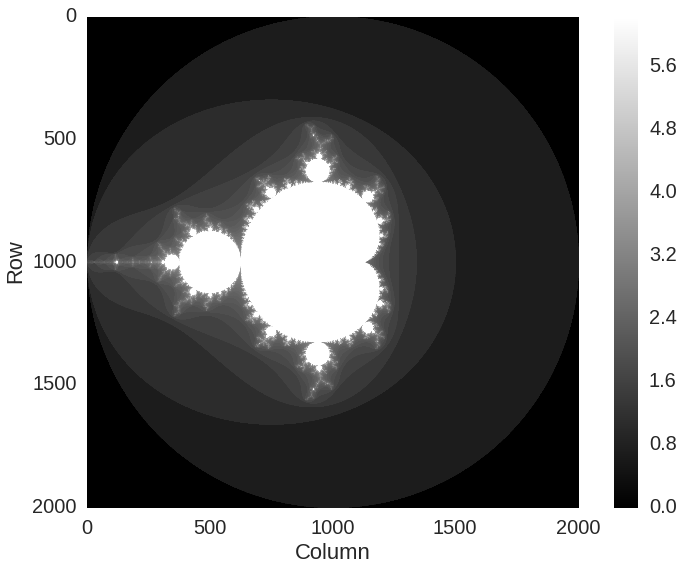

In [70]:
plt.grid(False)
P2.draw_image(data=mandelbrot_result)
plt.colorbar()
plt.xlabel('Column')
plt.ylabel('Row')

Beautiful. We have liftoff! Let's try to make that histogram now. I have now initialized the # of cores correctly, thankfully. How can we get a list of the work done on each partition...?

In [23]:
summed_rdd = P2.sum_values_for_partitions(mandelbrot_rdd)

In [24]:
summed_result = summed_rdd.collect()

In [27]:
len(summed_result)

100

Well, at least that has the correct shape...ok I get it. It sums the number of iterations taken to make this shape in each parition. So, the plot we need is

(array([ 82.,   4.,   0.,   0.,   2.,   0.,   0.,   2.,   0.,   0.,   0.,
          1.,   1.,   0.,   0.,   2.,   2.,   0.,   2.,   2.]),
 array([        0.,   1022000.,   2044000.,   3066000.,   4088000.,
          5110000.,   6132000.,   7154000.,   8176000.,   9198000.,
         10220000.,  11242000.,  12264000.,  13286000.,  14308000.,
         15330000.,  16352000.,  17374000.,  18396000.,  19418000.,
         20440000.]),
 <a list of 20 Patch objects>)

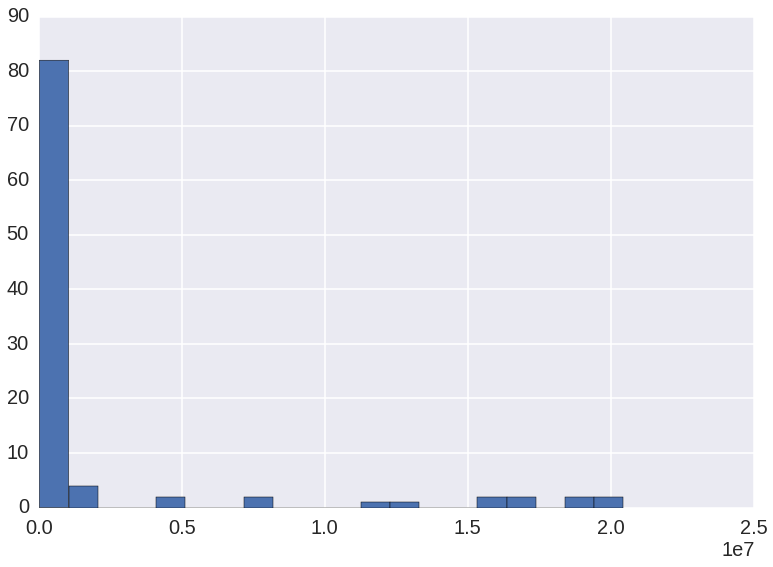

In [29]:
plt.hist(summed_result, bins=20)

We probably need a log scale...

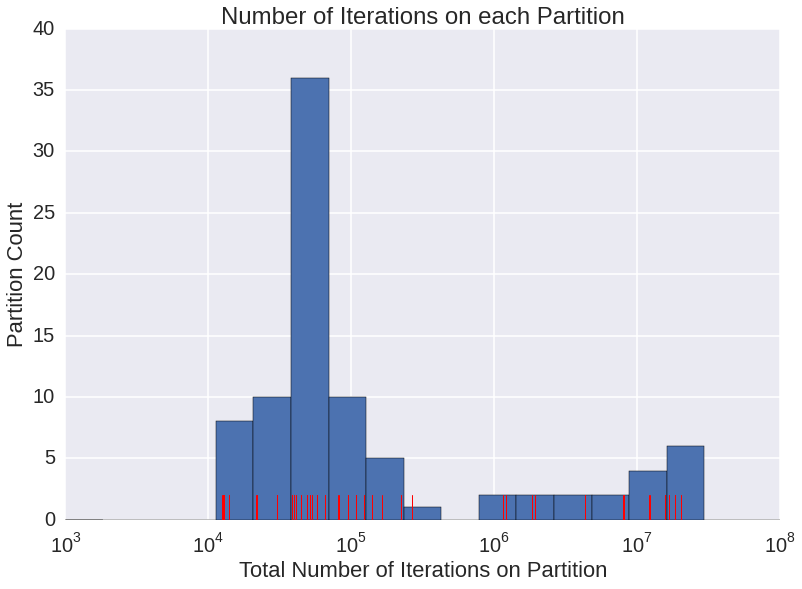

In [57]:
plt.hist(summed_result, bins=np.logspace(3, 8, 20))
sns.rugplot(summed_result, color='red')
plt.gca().set_xscale('log')
plt.xlabel('Total Number of Iterations on Partition')
plt.ylabel('Partition Count')
plt.title('Number of Iterations on each Partition')

Ok. This is instructive. The jobs run over several orders of magnitude. The rugplot is awesome because it gives you a real feeling of how many events there are distributed over space.

# Rebalancing the load

The question is: how do we predict how many iterations will occur for a given x,y? We need to make the load equally balanced across all partitions. We still must use 100 partitions. Is there a way we can predict how many iterations a given x, y will take? 

Not really. It's  a fractal. But we can make some general rules. If we are only load balancing based on row & column position, which is what I expect, we can define a prior-function to control how long we think things will take. Why don't we just make it radial.

In [71]:
muffin = complex(-1, .1)

In [79]:
def get_predicted_num_iterations(row, col):
    cur_position = np.array([row, col])
    center = np.array([num_pixels/2, num_pixels/2])
    distance_away = np.sqrt(np.sum((cur_position - center)**2))
    if distance_away <= 600:
        return 10.**5.
    else: 
        return 10.**3.
    return distance_away

In [117]:
def get_predicted_num_iterations(row, col):
    cur_position = np.array([row, col])
    row_cond = (550 < row) and (row < 1450)
    col_cond = (300 < col) and (col < 1200)
    if row_cond and col_cond:
        return 10**6
    else:
        return 10**3

Are these parameters reasonable? We can sketch.

In [118]:
predicted_iteration_rdd = indices.map(lambda a: (a, get_predicted_num_iterations(*a)))

In [119]:
predicted_iteration_results = predicted_iteration_rdd.collect()

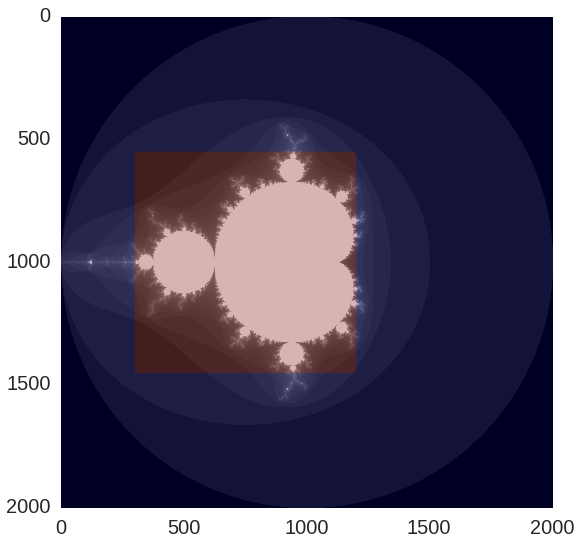

In [120]:
plt.grid(False)
P2.draw_image(data=mandelbrot_result)
P2.draw_image(data=predicted_iteration_results, alpha=0.3, cmap=plt.cm.jet)

It may be easier to just create an array and then grab data from it. Probably use it as a broadcast variable.

In [131]:
import skimage as ski
import skimage.io

In [152]:
expensive_mask = np.zeros((num_pixels, num_pixels))
e_top = 550
e_bottom = 1450
e_left = 300
e_right = 1250

expensive_mask[e_top:e_bottom, e_left:e_right] = 1
expensive_mask[1250:e_bottom, e_left:650]=0
expensive_mask[e_top:750, e_left:650]=0
expensive_mask[990:1010, 0:e_left]=1

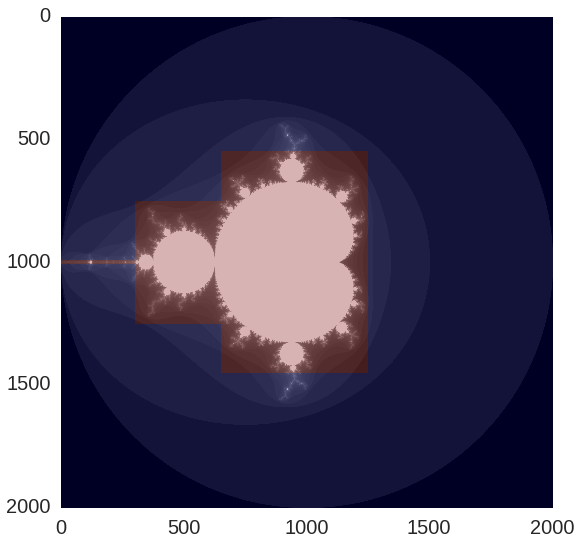

In [153]:
plt.grid(False)
P2.draw_image(data=mandelbrot_result)
ski.io.imshow(expensive_mask, alpha=0.3, cmap=plt.cm.jet)

This should work well. Awesome.